# PROJETO FINAL
INTRODUÇÂO AO PROCESSAMENTO DE IMAGENS


Prof. Bruno Luiggi Macchiavello Espinoza


- Lucas Corrêa Boaventura - 211038262

- Gustavo - 211038235

# Bibliotecas

In [269]:
import numpy as np
from PIL import Image
from IPython.display import display
import cv2
import matplotlib.pyplot as plt

from skimage import img_as_float
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage.draw import circle_perimeter
from skimage.segmentation import chan_vese

In [211]:
def READ(image):
    image = cv2.imread(image)
    resized_image = cv2.resize(image, (240,240), interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    return gray
    
def blurred(image):
    blurred_image = cv2.GaussianBlur(image, (15, 15), 0)
    return blurred_image

# Sobel



In [255]:
## Função para aplicar o filtro de Sobel
def Sobel(image):
    # Convertendo para escala de cinza
    blurr = blurred(image)
    # Aplicando o filtro Sobel nas direções x e y
    sobel_x = cv2.Sobel(blurr, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(blurr, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculando a magnitude total do gradiente
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalizando para exibir corretamente
    sobel_combined = cv2.convertScaleAbs(sobel_combined)
    
    return sobel_combined

def Canny(image):
    edges = cv2.Canny(image, 100, 200)
    
    return edges

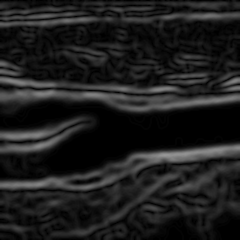

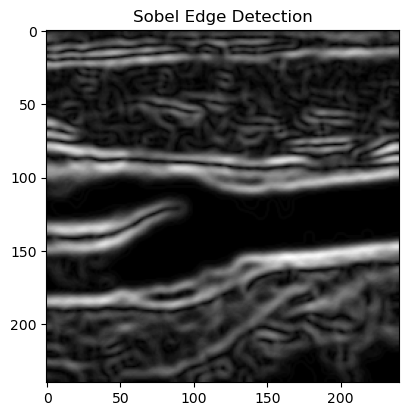

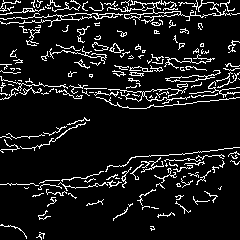

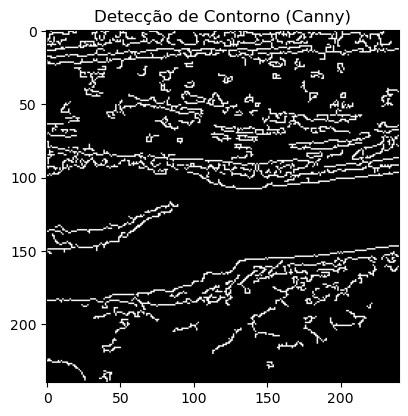

In [259]:
image = READ('tatiana.png')

# Aplicar o filtro de Sobel
sobel_image = Sobel(image)
canny_image = Canny(image)


display(Image.fromarray(sobel_image))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(sobel_image, cmap='gray')
plt.title('Sobel Edge Detection')
plt.show()

display(Image.fromarray(canny_image))
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.imshow(canny_image, cmap='gray')
plt.title('Detecção de Contorno (Canny)')
plt.show()

In [246]:
# Função para aplicar a detecção de bordas com Laplaciano
def LaplacianEdge(image):
    filtered_image = cv2.Laplacian(image, ksize=1, ddepth=cv2.CV_16S)
    filtered_image = cv2.convertScaleAbs(filtered_image)
    
    
    return filtered_image
    
def post_processing(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    closing_image = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening_image = cv2.morphologyEx(closing_image, cv2.MORPH_OPEN, kernel)
    return opening_image


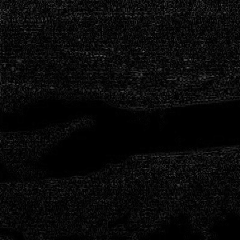

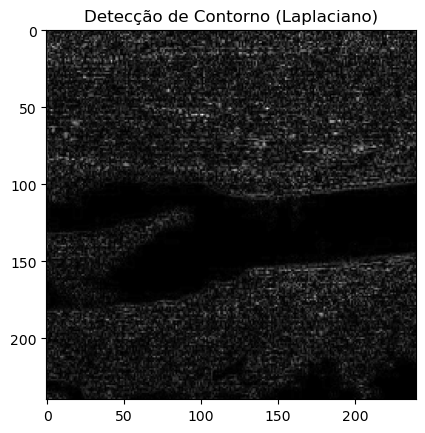

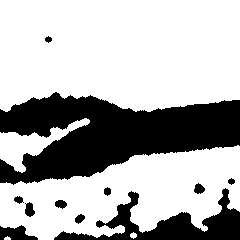

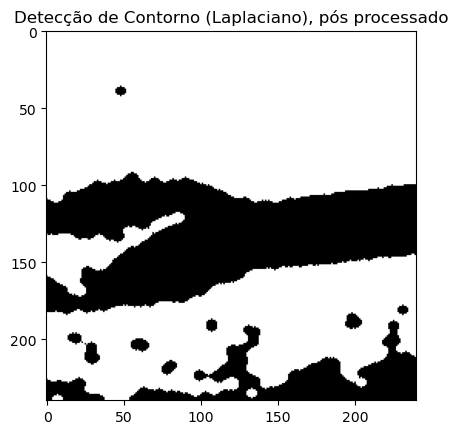

In [260]:


# Carregar a imagem
image = READ('tatiana.png')

laplacian_image = LaplacianEdge(image)
post_laplacian = post_processing(laplacian_image)

display(Image.fromarray(laplacian_image))

plt.imshow(laplacian_image, cmap='gray')
plt.title('Detecção de Contorno (Laplaciano)')
plt.show()

display(Image.fromarray(post_laplacian))
plt.imshow(post_laplacian, cmap='gray')
plt.title('Detecção de Contorno (Laplaciano), pós processado')
plt.show()



In [261]:
def snakes(image, init_level, ball, thresh):

    float_image = img_as_float(image)
    gradient = inverse_gaussian_gradient(float_image)
    init_level_set = np.zeros(image.shape, dtype=np.int8)
    rr, cc = circle_perimeter  (init_level[0], init_level[1], init_level[2])  # círculo inicial
    init_level_set[rr, cc] = 1
    
    snake = morphological_geodesic_active_contour(gradient, num_iter=160,
                                              init_level_set=init_level_set,
                                              smoothing=1, balloon=ball,
                                              threshold=thresh)
    return snake

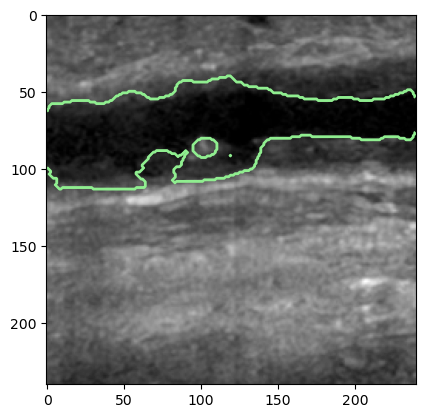

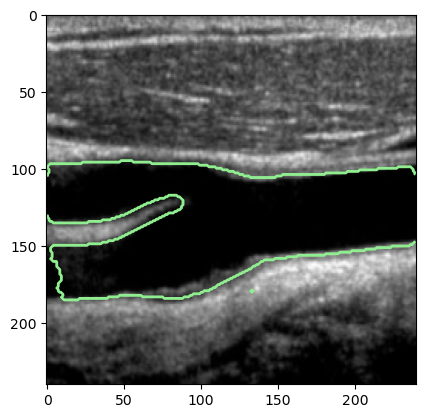

In [268]:
image = READ('arteria_simples.jpg')
blurred_image = blurred(image)
snake = snakes(blurred_image,(70,120,30), 9, 8)

plt.imshow(image, cmap="gray")
plt.contour(snake, 1, colors='lightgreen')
plt.show()

image = READ('tatiana.png')
blurred_image = blurred(image)
snake = snakes(blurred_image,(150,130,30), 1, 0.9)

plt.imshow(image, cmap="gray")
plt.contour(snake, 1, colors='lightgreen')
plt.show()

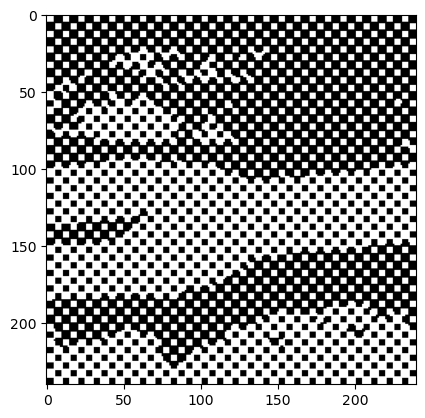

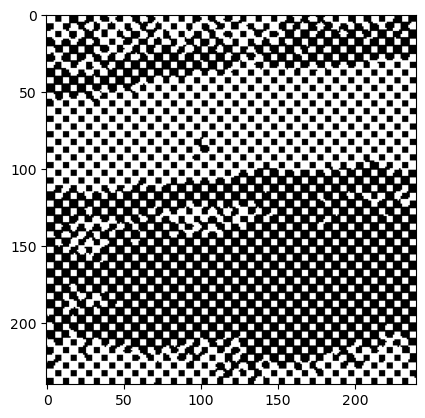

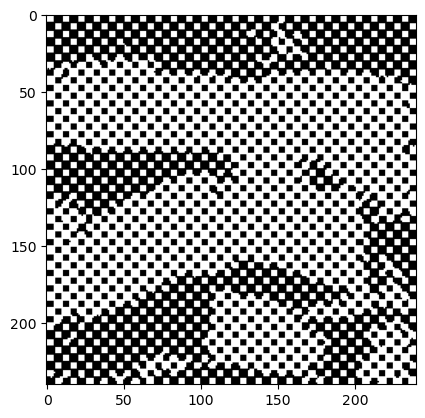

In [310]:
image = READ('tatiana.png')
blurr = blurred(image)

segmentation = chan_vese(blurr, mu=0.25, lambda1=1, lambda2=1, max_num_iter=100, tol=1e-3)

plt.imshow(segmentation, cmap='gray')
plt.show()

image = READ('arteria_simples.jpg')

segmentation = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, max_num_iter=100, tol=1e-3)

plt.imshow(segmentation, cmap='gray')
plt.show()

image = READ('arteria_dupla.jpg')

segmentation = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, max_num_iter=100, tol=1e-3)

plt.imshow(segmentation, cmap='gray')
plt.show()

